In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, QuadGK, SpecialFunctions
using TwoFAST, LaTeXStrings, LsqFit, MaximumLikelihoodPower

In [5]:
tab_pk = readdlm("../test/datatest/file_pk.txt", comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);

\begin{equation}
    \tilde{I}^4_0 (s) = \int \frac{dq}{2\pi^2} q^2P(q) \frac{j_0(qs) - 1}{(qs)^4}
\end{equation}

In [26]:
function func_I04_tilde(PK, s, kmin, kmax; kwargs...)
     res = quadgk(lq -> (sphericalbesselj(0, s * exp(lq)) - 1.0) * PK(exp(lq)) / (2.0 * π^2 * exp(lq)),
          log(kmin), log(kmax); kwargs...)[1]

     return res / (s^4)
end

function expanded_I04_tilde(PK, ss, kmin, kmax; kwargs...)

     fit_1, fit_2 = 0.1, 1.0
     fit_3, fit_4 = 1e3, 1e4
    
    if all(fit_1 .< ss .< fit_4)
        return [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in ss]
        
    elseif all(ss .> fit_1)
        cutted_ss = ss[ss .< fit_4]
        cutted_I04_tildes = [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in cutted_ss]
        r_si, r_b, r_a = GaPSE.power_law_from_data(cutted_ss, cutted_I04_tildes,
             [-4.0, -1.0, 0.0], fit_3, fit_4; con = true)
        println("r_si, r_b, r_a = $r_si , $r_b , $r_a")
        right_I04_tildes = [GaPSE.power_law(s, r_si, r_b, r_a) for s in ss[ss.>=fit_4]]

        return vcat(cutted_I04_tildes, right_I04_tildes)
        
    elseif all(ss .< fit_4)
        cutted_ss = ss[ss .> fit_1]
        cutted_I04_tildes = [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in cutted_ss]
        l_si, l_b, l_a = GaPSE.power_law_from_data(cutted_ss, cutted_I04_tildes,
          [-2.0, -1.0, 0.0], fit_1, fit_2; con = true)
        println("l_si, l_b, l_a = $l_si , $l_b , $l_a")
        left_I04_tildes = [GaPSE.power_law(s, l_si, l_b, l_a) for s in ss[ss.<=fit_1]]
        
        return vcat(left_I04_tildes, cutted_I04_tildes)
        
    else
        cutted_ss = ss[fit_1 .< ss .< fit_4]
        cutted_I04_tildes = [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in cutted_ss]

        l_si, l_b, l_a = GaPSE.power_law_from_data(cutted_ss, cutted_I04_tildes,
          [-2.0, -1.0, 0.0], fit_1, fit_2; con = true)
        println("l_si, l_b, l_a = $l_si , $l_b , $l_a")
        r_si, r_b, r_a = GaPSE.power_law_from_data(cutted_ss, cutted_I04_tildes,
         [-4.0, -1.0, 0.0], fit_3, fit_4; con = true)
        println("r_si, r_b, r_a = $r_si , $r_b , $r_a")
        left_I04_tildes = [GaPSE.power_law(s, l_si, l_b, l_a) for s in ss[ss.<=fit_1]]
        right_I04_tildes = [GaPSE.power_law(s, r_si, r_b, 0.0) for s in ss[ss.>=fit_4]]

        I04_tildes = vcat(left_I04_tildes, cutted_I04_tildes, right_I04_tildes)

        return I04_tildes  
    end
end

expanded_I04_tilde (generic function with 1 method)

In [7]:
tab_mattia_I04_tildes = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/I40_tilde.txt");
mattia_I04_ss = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,1]);
mattia_I04_tildes = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,2]);
my_I04_tildes = expanded_I04_tilde(PK, mattia_I04_ss, k_min, k_max);

l_si, l_b, l_a = -2.0004511703769805 , -16.798305909799886 , 0.05899754740072086
r_si, r_b, r_a = -3.247836898278813 , -2596.1202245993336 , 1.1062360215862807e-7


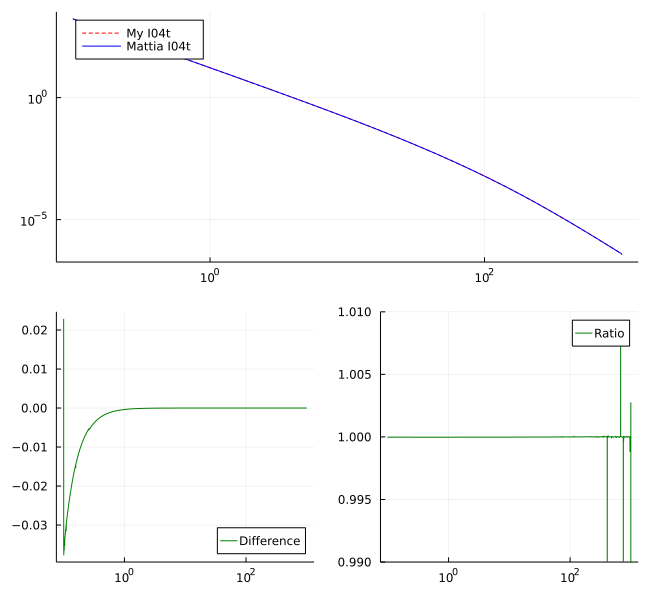

In [8]:
xs = mattia_I04_ss
ys = -mattia_I04_tildes
#spline = cosmo.tools.I04_tilde
my_ys = -my_I04_tildes

p1 = plot([xs[my_ys .>0], xs], [my_ys[my_ys .>0],  ys], xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["My I04t" "Mattia I04t"], ls=[:dash :solid], legend=:topleft)

p2 = plot(xs, my_ys .- ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(xs, my_ys ./ ys, label="Ratio", lc=:green, xaxis=:log, ylim=(0.99, 1.01))

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

In [21]:
ys

1000-element Vector{Float64}:
 -1.6844037547020903e9
 -1.6234100922661943e9
 -1.564625061131861e9
 -1.5079686849207075e9
 -1.4533638832655914e9
 -1.400736366943656e9
 -1.350014536806649e9
 -1.3011293863710918e9
 -1.2540144079357378e9
 -1.2086055020985672e9
 -1.1648408905502892e9
 -1.122661032025622e9
 -1.0820085412980754e9
  ⋮
 -1.8549732511358803e-10
 -1.7313725272105965e-10
 -1.6159764013544917e-10
 -1.5082426428542612e-10
 -1.4076645695949675e-10
 -1.3137693510250496e-10
 -1.2261135094835657e-10
 -1.1442853848174591e-10
 -1.0678987400548764e-10
 -9.965931348880773e-11
 -9.300319943669314e-11
  1.1669978492595714e-10

l_si, l_b, l_a = -2.0002426691026707 , -16.80643206973945 , 0.10631034214382579
r_si, r_b, r_a = -3.5576615791520236 , -18690.30126327758 , 2.2659277369465054e-10


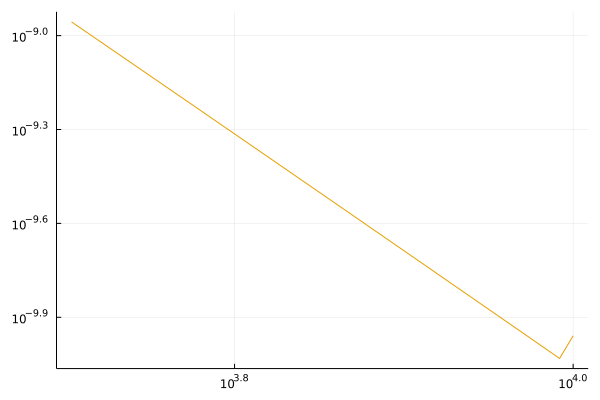

In [30]:
xs = 10 .^ range(-4, 4, length=1000)
ys = expanded_I04_tilde(PK, xs, k_min, k_max)
plot(xs[xs.>5e3], -ys[xs.>5e3], legend=false, xaxis=:log, yaxis=:log)

r_si, r_b, r_a = -3.2495775167258723 , -2622.450267186715 , 1.0857542800359785e-7


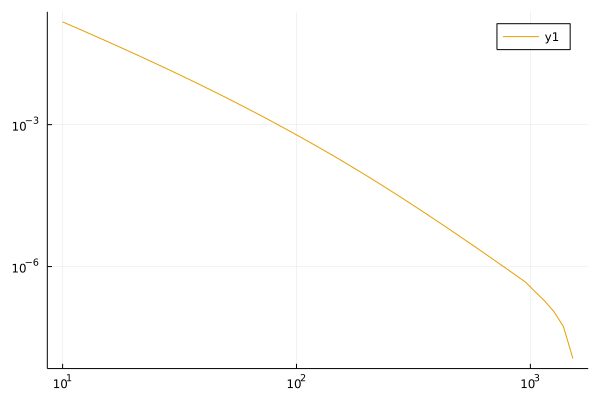

In [7]:
xs = 10 .^ range(1, 5, length=100)
ys = expanded_I04_tilde(PK, xs, k_min, k_max)
plot(xs[-ys .>0], -ys[-ys .>0], xaxis=:log, yaxis=:log
    )

In [8]:
xs = 10 .^ range(3,4, length=100)
ys = [func_I04_tilde(PK, x, k_min, k_max) for x in xs]
#GaPSE.power_law_from_data(xs, ys, [-4.0, -1.0]; con=false)
GaPSE.mean_spectral_index(xs, ys; N=3, con=false)

-3.701410210979164

In [24]:
GaPSE.power_law(1e4, -3.2495775167258723 , -2622.450267186715 , 0.0)

-2.632674664124768e-10